# TODO:
- Add something to add a minimap to the delta_twtt plot to show one point in the general area of the crossover points for quick reference
    - or add a plot to the side which displays the continent and a "you are here" star marker IVO the crossover points
- **Implement multi flight crossover point finding**
- Multi flight plotting
    - how many flights could I put in a file together? i.e. can I save a full season to one file in the pickle format?
- scaling for overall depth in twtt? i.e. less effect in shallower ice so you can't really compare to deeper ice CX points



In [121]:
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.transforms import ScaledTranslation

from project_classes import *
from functions import *
# from scipy.optimize import curve_fit
# import scipy.optimize as opt

In [2]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
season = "2018_Antarctica_DC8" 
season = "2016_Antarctica_DC8" 
# season = "2014_Antarctica_DC8" 
# season = "2022_Antarctica_BaslerMKB"

# flight = "20181030_01"  # the flight date and frame number 
    # that flight only has one point
# flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181011_01"
    # one dimensional data error
    # TODO: figure out why 10018 and 1103 have the same data or at least print the same maps and plots
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
    # plots fake crossovers along the curved path
# flight = "20161024_05"
# flight = "20161111_05"
    # probably too close to the coast to be useful
flight = "20161024_05"
# flight = "20141025_05"
# flight = "20141026_06"
    # this one is 1/3 of an orbit and produces a bunch of bunk crossovers
# flight = "20230127_01"
    # ~ 1/3 of an orbit of the pole and yet the angle plot looks like hot garbage
# flight = "20230125_01"
# flight = "20221229_01"
# file_name = "layer_export_" + flight + ".pickle"
file_name = f"pickle_jar\\layer_export_{flight}.pickle"
# file_name = "C:\\Users\\rj\\Desktop\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
# file_name = f"C:\\Users\\{username}\\Desktop\\cresis_project\\pickle_jar\\{season}_{flight}_layers.pickle"
testing = False

In [3]:
"""
read in the layers from the layer files and save them to a pickle file
"""
force = False
# force = True
whole_season = False
# whole_season = True

if whole_season:
    print(type(dir))
    file_name = dir + season + ".pickle"
    # print(f"filename: {filename}")
    if not os.path.isfile(file_name):  # if the file does not exist
        debug_print(BRIGHT_RED, f"File {file_name} does not exist. You should make it...")
    else:
        layers = read_layers(file_name)
        print(f"File {file_name} loaded.")
else:
    if not force:
        if not os.path.isfile(file_name):  # if the file does not exist
            print(f"File {file_name} does not exist. Making it...")
            mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
            layers = read_layers(file_name)  # read in the layers from the pickle file
            print(f"File {file_name} created.")
        else:
            layers = read_layers(file_name)  # read in the layers from the pickle file
            print(f"File {file_name} loaded.")
    else:
        mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
        layers = read_layers(file_name)  # read in the layers from the pickle file

Reading pickle file...
--------------------
Surface
Bottom
--------------------

File pickle_jar\layer_export_20161024_05.pickle loaded.


### read in the iceflow data from the iceflow data files and save them to a pickle file

In [4]:
if not os.path.isfile("C:\\Users\\moser\\Desktop\\cresis_project\\iceflow\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\moser\\Desktop\\cresis_project\\iceflow\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]
print("iceflow data loaded")

The iceflow data pickle file was found and loaded.
iceflow data loaded


In [5]:
# if the file at filename exists, read in the intersect_indices and intersection_points from the pickle file
# otherwise, find the intersect_indices and intersection_points and save them to a pickle file
force_redo_intersections = False
# force_redo_intersections = True
filename = f"C:\\Users\\moser\\Desktop\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"
if not os.path.isfile(filename) or force_redo_intersections:  # if the file does not exist
    print(f"File {filename} does not exist. Making it...")
    intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
    with open(filename, 'wb') as file:
        pickle.dump(intersection_indices, file)
        pickle.dump(intersection_points, file)
        pickle.dump(segment_ends, file)
    print(f"intersection_indices and intersection_points saved to {filename}")
else:
    with open(filename, 'rb') as file:
        intersection_indices = pickle.load(file)
        intersection_points = pickle.load(file)
        segment_ends = pickle.load(file)
    print(f"intersection_indices and intersection_points loaded from {filename}")

intersection_indices and intersection_points loaded from C:\Users\moser\Desktop\cresis_project\pickle_jar\2016_Antarctica_DC8_20161024_05_crossover_points.pickle


In [150]:
# TODO: identify why this is still here and not in the functions file
    # because it is still being tweaked
# TODO: consider normalizing to the elevation, not the surface
    # i.e. instead of having the surface be flat, have it represent the actual topology
    # really only useful for places where the surface is not basically flat 
def plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=False, refractive_index=1.77, cross_index=0, filename=None):
    """
    :param layers: a list of Layer objects
    :param intersection_indices: a list of indices in the lat-lon arrays where the flight path
    crosses over itself
    :param intersection_points: a list of lat-lon points where the flight path crosses over itself
    :return: nothing (plots the layers and the map)
    """
    micro = chr(956)
    def s_to_ms(x, pos):
        """
        :param x: the x value
        :param pos: the position
        :return: the x value in milliseconds
        """
        return '%1.2f' % (x * 1e6)

    # plt.figure(figsize=(16, 8), layout='constrained')
    fig, ax = plt.subplots(figsize=(16, 8), layout='constrained')
    # print("Plotting layers...")
    # print("--------------------")
    # print("Adjusting for surface twtt...")
    for layer in layers:
        corrected_layer = layer.twtt - layers[0].twtt
        layer.twtt_corrected = corrected_layer


    # offset = 500
    offset = 30

    ax.plot(
        layers[1].twtt_corrected[intersection_indices[cross_index][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[1].layer_name + ' segment 1')
    ax.plot(
        layers[1].twtt_corrected[intersection_indices[cross_index][1] - offset:intersection_indices[cross_index][1] + offset],
        label=layers[1].layer_name + ' segment 2')

    plt.gca().invert_yaxis()
    # plot the crossover point on the plot 
    ax.scatter(offset, layers[1].twtt_corrected[intersection_indices[cross_index][0]], color='red', label='X Point 1')
    ax.scatter(offset, layers[1].twtt_corrected[intersection_indices[cross_index][1]], color='green', label='X Point 2')
    
    n = refractive_index
    c = 299792458  # m/s
    v = c / n
    # depth = twtt * v / 2
    scale_factor = v / 2
    
    # print the twtt at the crossover point on both segments
    # twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=)
    twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[cross_index]
    print(f"twtt: {twtt}")
    
    
    # plot a line at the crossover point
    ax.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)
    ax.axhline(y=twtt[0], color='red', label='X Point 1', linestyle='--', linewidth=0.3)
    ax.axhline(y=twtt[1], color='green', label='X Point 2', linestyle='--', linewidth=0.3)
    
    # plot a line from twtt[0] to twtt[1] to show the delta twtt
    delta_twtt = twtt[1] - twtt[0]
    delta_twtt_ms = float(s_to_ms(delta_twtt, None))
    ax.plot([offset*0.1, offset*0.1], [twtt[0], twtt[1]], color='black', label='Delta TWTT', linewidth=0.3)
    ax.text(offset*0.08, (twtt[0] + twtt[1]) / 2, f"{delta_twtt_ms:.3f}{micro}s", fontsize='smaller', ha='right', va='center', color='black')
    
    # plot a line from twtt[0] to twtt[1] to show the delta twtt in meters
    delta_depth = twtt_to_depth(delta_twtt, refractive_index=n)
    ax.plot([offset*1.9, offset*1.9], [twtt[0], twtt[1]], color='black', label='Delta Depth', linewidth=0.3)
    ax.text(offset*1.92, (twtt[0] + twtt[1]) / 2, f"{delta_depth:.3f}m", fontsize='smaller', ha='left', va='center', color='black')
    
    # plot a horizontal line from (offset - 5) to (offset + 5) to show the distance scale
    start = layers[1].twtt_corrected[intersection_indices[cross_index][0] - 5]
    end = layers[1].twtt_corrected[intersection_indices[cross_index][0] + 5]
    # the y axis is inverted so the minimum is the maximum
    for point in range(intersection_indices[cross_index][0] - 5, intersection_indices[cross_index][0] + 5):
        if layers[1].twtt_corrected[point] > start:
            start = layers[1].twtt_corrected[point]
            # print(f"start: {start}")
    for point in range(intersection_indices[cross_index][1] - 5, intersection_indices[cross_index][1] + 5):
        if layers[1].twtt_corrected[point] > start:
            start = layers[1].twtt_corrected[point]
            # print(f"start: {start}")
    minimum = max(start, end)
    pixel_offset = 20  # offset 20 pixels
    trans = ax.transData + ScaledTranslation(0, -pixel_offset / fig.dpi, ax.figure.dpi_scale_trans)
        
    ax.plot([offset - 5, offset + 5], [minimum, minimum], transform=trans, color='black', label='Distance Scale', linewidth=0.3)
    location1_lat = layers[1].lat[intersection_indices[cross_index][0] - 5]
    location1_lon = layers[1].lon[intersection_indices[cross_index][0] - 5]
    location2_lat = layers[1].lat[intersection_indices[cross_index][0] + 5]
    location2_lon = layers[1].lon[intersection_indices[cross_index][0] + 5]
    distance = latlon_dist((location1_lat, location1_lon), (location2_lat, location2_lon))
    # ax.text(offset, minimum, f"{distance:.2f}m", fontsize='smaller', ha='center', va='top', color='black')
    ax.annotate(f"{distance:.3f}m", (offset, minimum), xycoords='data', xytext=(0, -5), textcoords='offset points', fontsize='smaller', ha='center', va='top', color='black')
        # because the plane is moving so fast, speed is constant → distance is constant → this value will be the same in each plot
    
    # set the y axis to be in microseconds instead of seconds
    plt.ylabel(f"Adjusted Two Way Travel Time ({micro}s)")
    plt.xlabel("Index")

    # force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    

    # set the y axis to be in microseconds instead of seconds
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))
        # set 5 subticks on the y axis
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.000000005))
    # ax.gca().yaxis.set_minor_locator(ax.MultipleLocator(0.5 / 1e6))
    plt.legend( fontsize='smaller', loc='lower right')

    # make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
    min_y, max_y = plt.ylim()
    # n = refractive_index
    # c = 299792458  # m/s
    # v = c / n
    # # depth = twtt * v / 2
    # scale_factor = v / 2
    # print(f"scale factor: {scale_factor}")
    plt.twinx()
    plt.ylim(min_y * scale_factor, max_y * scale_factor)
    plt.ylabel("Depth (m)")

    # make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
    min_x, max_x = plt.xlim()
    scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
    # print(f"scale factor: {scale_factor}")
    plt.twiny()
    plt.xlim(min_x * scale_factor, max_x * scale_factor)
    plt.xlabel("Distance (m)")

    plt.title(f"Adjusted Two Way Travel Time vs Index\n Cross Index {cross_index + 1}")
    
    dir = f"C:\\Users\\{username}\\Desktop\\cresis_project\\screens\\"
    file_name = f"{season}_{flight}_twtt_vs_index_cross_{cross_index + 1}"
    plt.savefig(f"{dir}{file_name}.png", dpi=250)
    
    plt.show()


def plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=None):
    """
    plot the map
    """
    plot_it = True
    printout = False
    
    if plot_it:
        plt.figure(figsize=(16, 8), layout='constrained')
    print("Plotting map...")
    # TODO: add an offset to the zoom settings so that the crossover point is in the center of the zoomed in map
    offset = 500  # this is not that offset

    # this code sets up a polar stereographic map of antarctica with the South Pole in the center
    zoom_out_to_continent = not zoom
    if zoom_out_to_continent:
        llcrnrx = -400000
        llcrnry = -400000
        urcrnrx = 250000
        urcrnry = 250000
    else:
        llcrnrx = -100000
        llcrnry = -100000
        urcrnrx = 100000
        urcrnry = 100000
    lat_0 = intersection_points[cross_index][0]
    lon_0 = intersection_points[cross_index][1]
    # print(f"debug: lat_0: {lat_0}, lon_0: {lon_0}")
    if plot_it:
        m = Basemap(projection='ortho', lat_0=lat_0, lon_0=lon_0, llcrnrx=llcrnrx, llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='h')
        # m = Basemap(projection='spstere', lat_0=-90, lat_ts=-71, lon_0=0, boundinglat=-80, resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='grey', lake_color='aqua')
        m.drawparallels(np.arange(-80., 81., 20.))
        m.drawmeridians(np.arange(-180., 181., 20.))
        m.drawmapboundary(fill_color='aqua')
    
        # plot the flight path
        m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
        # plot the section of the flight path in the plot above
        m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
               layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
               color='red', linewidth=1)
        m.plot(layers[0].lon[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
               layers[0].lat[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset], latlon=True,
               color='green', linewidth=1)
        # plot labels for the flight paths at their start points
        plt.text(
            m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[0],
            m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[1],
            '\nsegment 1', fontsize='smaller', fontweight='bold', ha='right', va='top', color='red')
        plt.text(
            m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[0],
            m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[1],
            '\nsegment 2', fontsize='smaller', fontweight='bold', ha='left', va='top', color='green')
        # plot the South Pole
        # m.scatter(0, -90, latlon=True, color='black', linewidth=1, label='South Pole')
        # plot the crossover points
        for point in intersection_points:
            m.scatter(point[1], point[0], latlon=True, color='darkred', linewidth=1, label='Crossover Point')
            plt.text(m(point[1], point[0])[0], m(point[1], point[0])[1] - 10000, f'{intersection_points.index(point) + 1}\n\n',
                     fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # m.scatter(intersection_points[cross_index][1], intersection_points[cross_index][0], latlon=True, color='darkred',
    #           linewidth=1, label='Crossover Point')
    # plt.text(m(intersection_points[cross_index][1], intersection_points[cross_index][0])[0],
    #          m(intersection_points[cross_index][1], intersection_points[cross_index][0])[1] - 10000,
    #          'Crossover Point\n\n',
    #          fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # plot the the ice flow direction at the crossover point
    for i in range(len(intersection_indices)):
    # for i in range(1):
        cross_lat = intersection_points[i][0]
        cross_lon = intersection_points[i][1]
        if cross_lon < 0:
            cross_lon = 360 + cross_lon
        cross_x, cross_y = latlon_to_xy(cross_lat, cross_lon)  
        """Outputs x and y in EPSG:3031"""
    

        
        # nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(cross_x, cross_y, iceflow_data, max_radius=10)
        # nearest_y_index, nearest_x_index = latlon_to_nearest_unmasked_index(cross_lat, cross_lon, iceflow_data, max_radius=10)
        nearest_x_index, nearest_y_index = latlon_to_nearest_unmasked_index(cross_lat, cross_lon, iceflow_data, max_radius=10)
        
        """Outputs the nearest x and y indices to the x and y EPSG:3031 values"""
        
        
        nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]  # latitude = iceflow_data[4]
        nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]  # longitude = iceflow_data[5]
        # nearest_lon = - (iceflow_data[5][nearest_x_index][nearest_y_index] - 270)  # longitude = iceflow_data[5]
        
        # print(f"nearest_lat: {nearest_lat:.4f}, nearest_lon: {nearest_lon:.4f}")
        

        nearest_x, nearest_y = index_to_x(nearest_x_index), index_to_y(nearest_y_index)
        
    
        # flow = flow_at_x_y_index(nearest_x_index, nearest_y_index, iceflow_data)
        vx, vy = iceflow_data[2][nearest_y_index][nearest_x_index], iceflow_data[3][nearest_y_index][nearest_x_index]
        flow = [vx, vy]
        
        
        flow_heading = xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow[0], flow[1])[0]
        # m.quiver(intersection_points[0][1], intersection_points[0][0], 1000 * np.cos(np.radians(flow_heading)),
        #          1000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        # plot the ice flow vector in the upper right corner as a quiver
        

        if printout:
            print(f"cross index: {i+1}")
            print(f"cross_lat: {cross_lat:.8}, cross_lon: {cross_lon:.8f}") 
            print(f"cross_x: {cross_x:.4f}, cross_y: {cross_y:.4f}")
            print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
            print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")
            print(f"nearest_x: {nearest_x:.4f}, nearest_y: {nearest_y:.4f}")
            print(f"flow at nearest: {flow}")
            print("")
            print(f"Diff x: {(cross_x - nearest_x):.1f}, Diff y: {(cross_y - nearest_y):.1f}")
            print("")
            print(section_break)
            print(section_break)
            print("")
        
        

        m.quiver(nearest_x, nearest_y, 10000 * np.cos(np.radians(flow_heading)), 10000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        x, y = m(0, -90)
    
        # plt.text(x, y, '\nSouth Pole', fontsize='smaller', fontweight='bold', ha='center', va='top', color='black')

    center_x, center_y = latlon_to_xy(intersection_points[cross_index][0], intersection_points[cross_index][1])
    center_x = x_to_index(center_x)
    center_y = y_to_index(center_y)
    search_range = 750
    steps = 50
    start_time = time.time()
    for x in range(-1 * search_range + center_x, search_range + center_x, steps):
        current = x + search_range - center_x    
        progress_bar(current,  2 * search_range, start_time)
        for y in range(-1 * search_range + center_y, search_range + center_y, steps):
            if not (
                np.ma.is_masked(iceflow_data[2][y][x]) and np.ma.is_masked(iceflow_data[3][y][x])
                ):

                vx = 1 * iceflow_data[2][y][x]
                vy = 1 * iceflow_data[3][y][x]
                flow = [vx, vy]
                flow_heading = xyindex_vector_to_heading(x, y, flow[0], flow[1])[0]
                scale = 0.0005
                mag = np.sqrt(vx**2 + vy**2) * scale
                lat = iceflow_data[4][y][x]
                lon = iceflow_data[5][y][x]
                m.scatter(lon, lat, latlon=True, color='darkred', s=0.75)
                # plot a line of length mag in the direction of the flow vector to show the flow vector
                endpt = [lon + mag * np.cos(np.radians(flow_heading)), lat + mag * np.sin(np.radians(flow_heading))]
                m.plot([lon, endpt[0]], [lat, endpt[1]], latlon=True, color='blue', linewidth=0.5)
                
            # else:
                # print(f"masked at x: {x}, y: {y}")
        # scatter the south pole
        # m.scatter(0, -90, latlon=True, color='white', s=5)
        # print("")
        
    print("")
    if plot_it: 
        plt.title("Lat-Lon Map")
        # set tight layout
        # plt.tight_layout()
    
        # save the plot
        if filename:
            # plt.savefig(f"{filename}.png", dpi=250)
            dir = "C:\\Users\\moser\\Desktop\\cresis_project\\screens\\"
            savename = f"{dir}{filename}_map.png"
            print(f"saving to {savename}...")
            plt.savefig(savename, dpi=150)
        
        print("drawing to screen...")
        plt.show()

    # print("plotted map")
    # print(section_break + "\n")

i: 0
twtt: [3.189429995299016e-05, 3.19310862694747e-05]


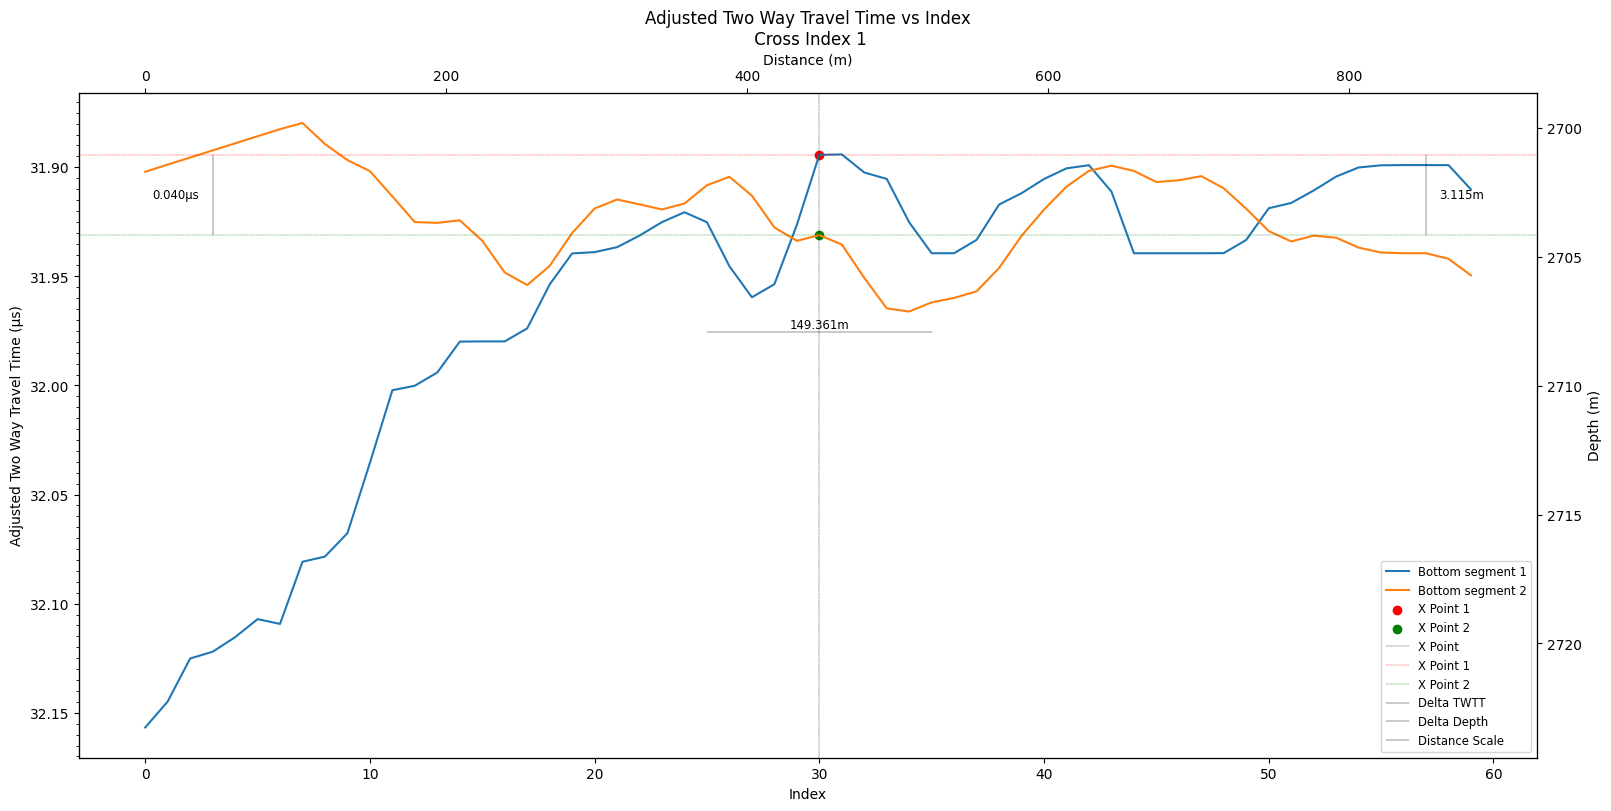

i: 1
twtt: [3.45252e-05, 3.459059522132102e-05]


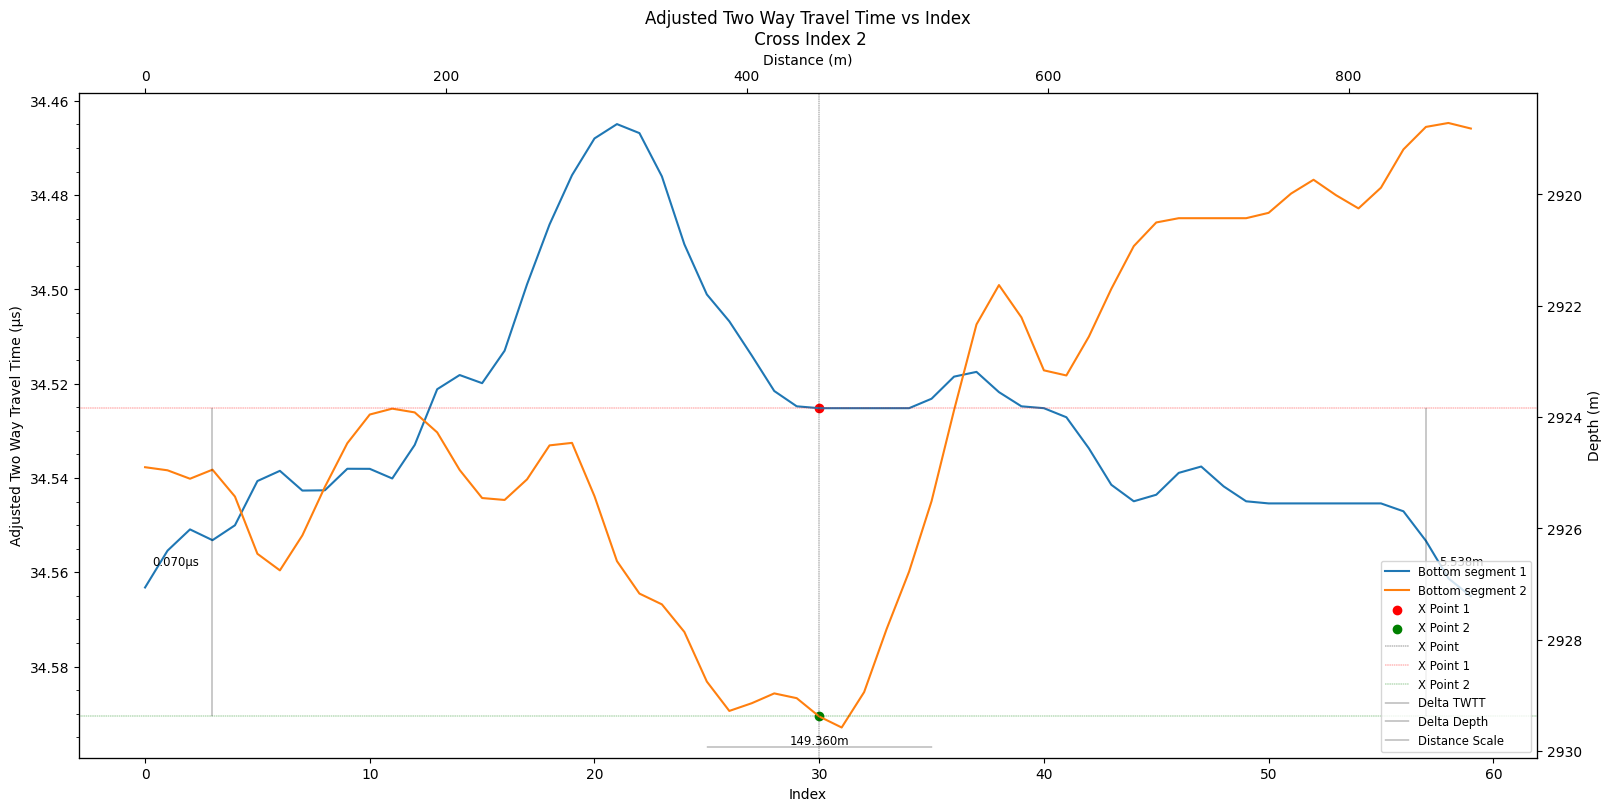

i: 2
twtt: [nan, nan]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


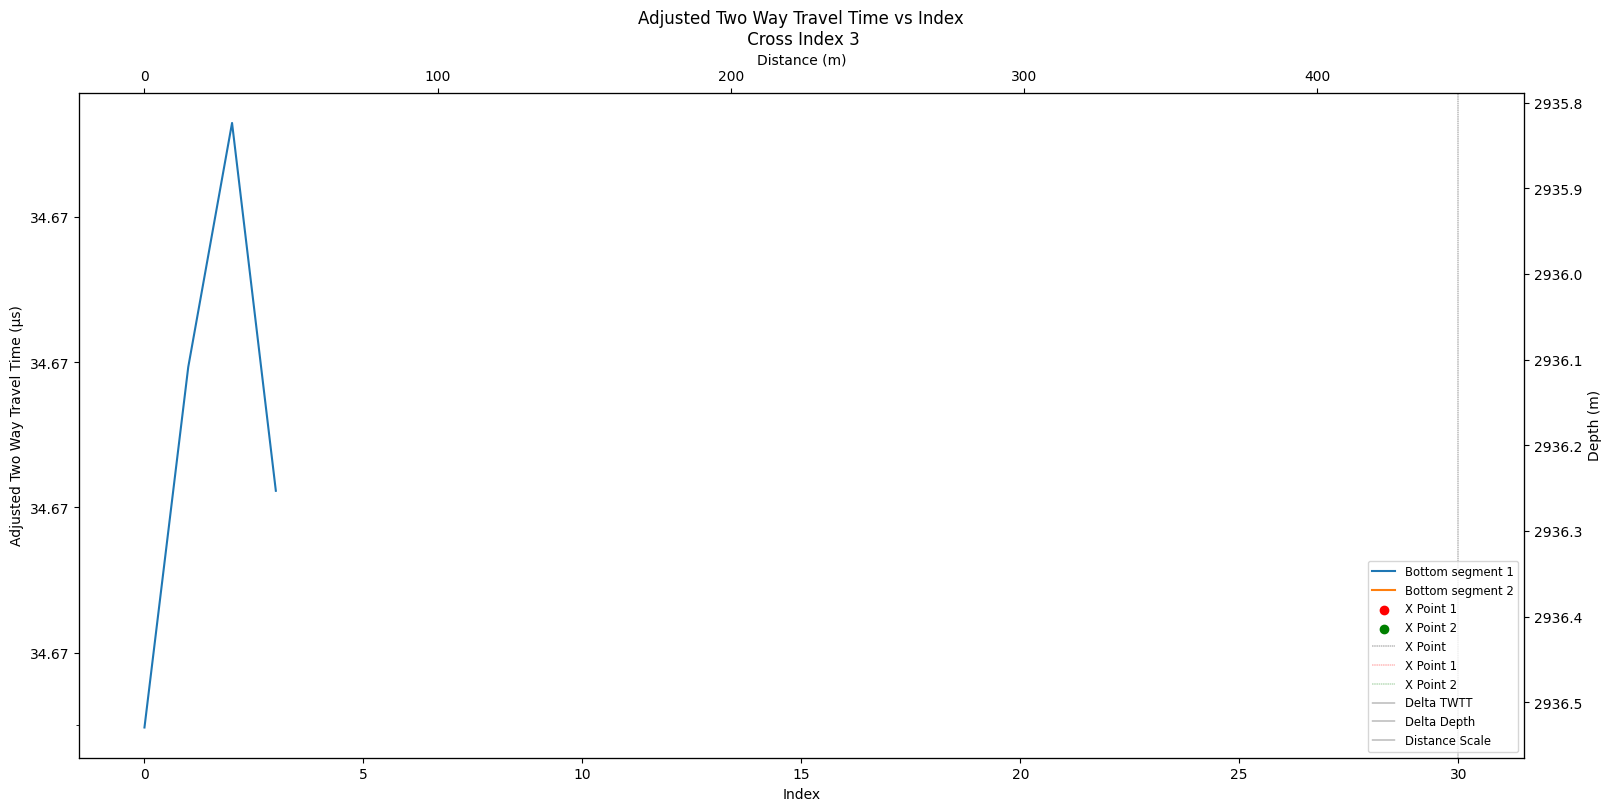

i: 3
twtt: [3.3373799999999995e-05, 3.3306490795203906e-05]


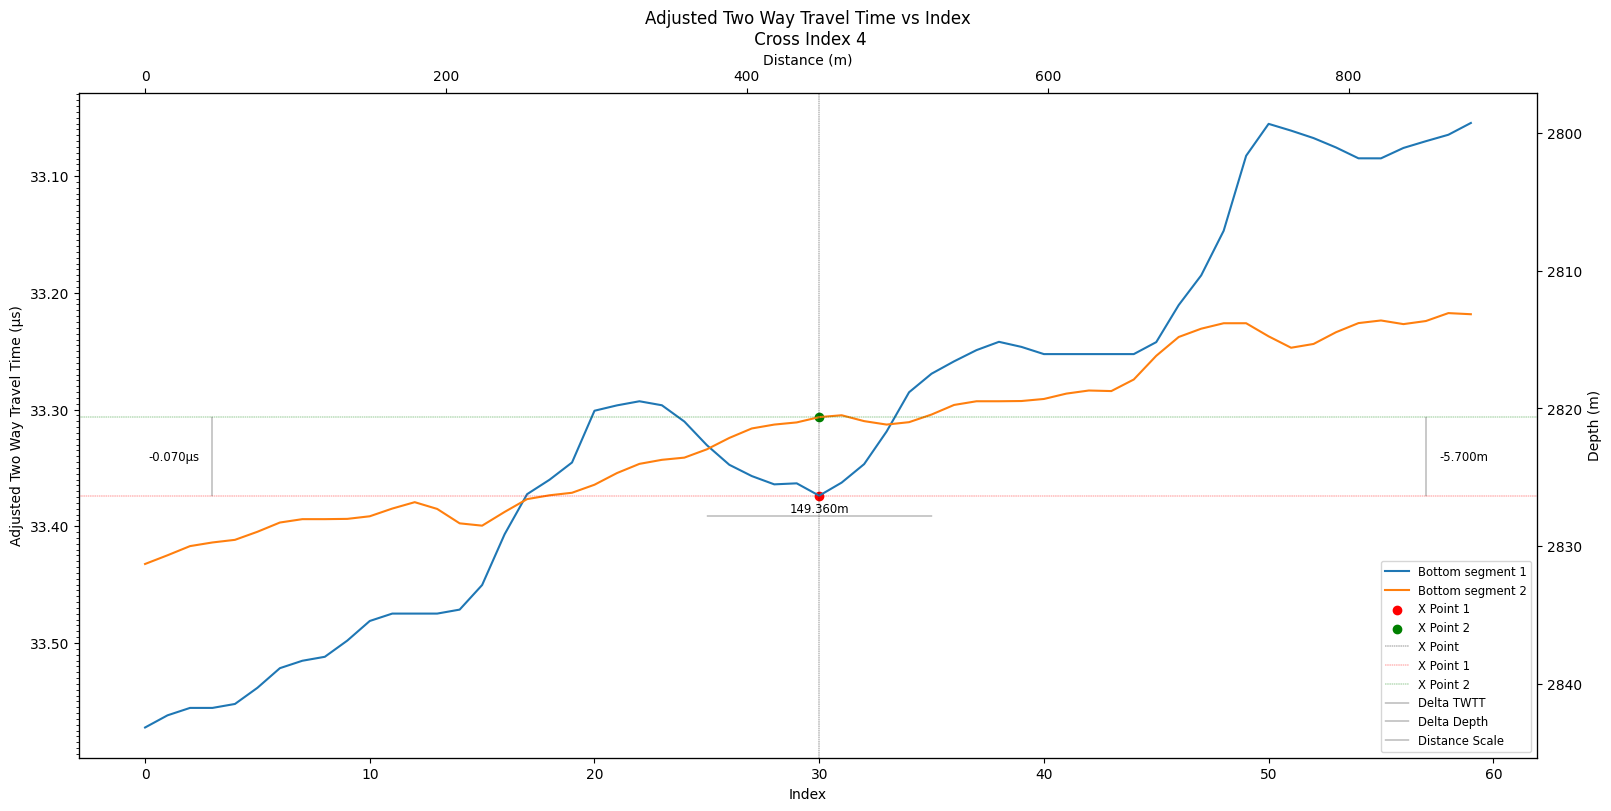

i: 4
twtt: [1.8413960828014443e-05, 1.8478186797910058e-05]


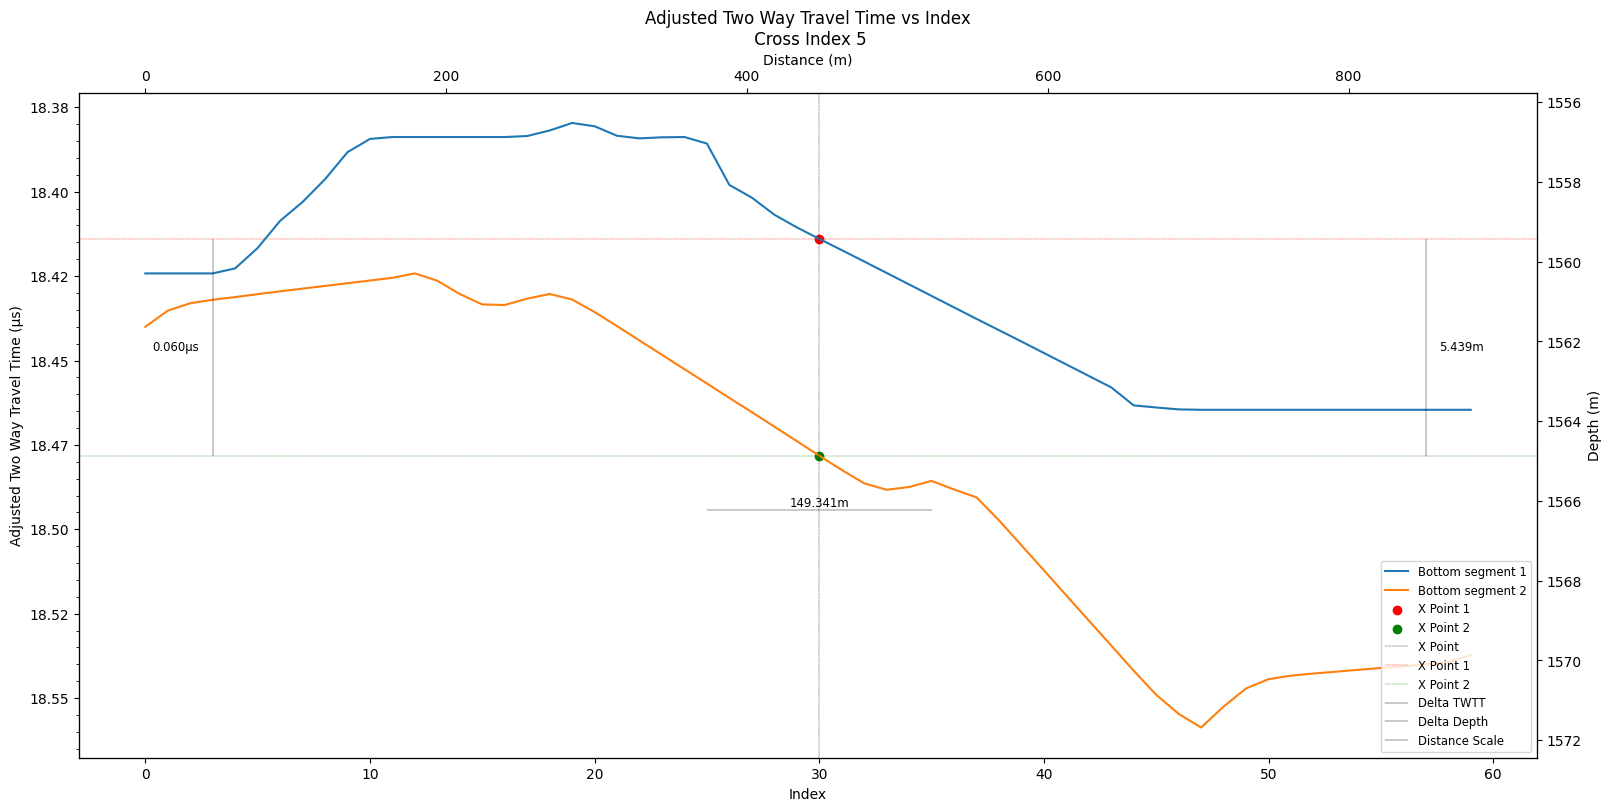

i: 5
twtt: [3.3324268156376655e-06, 4.160896194451775e-06]


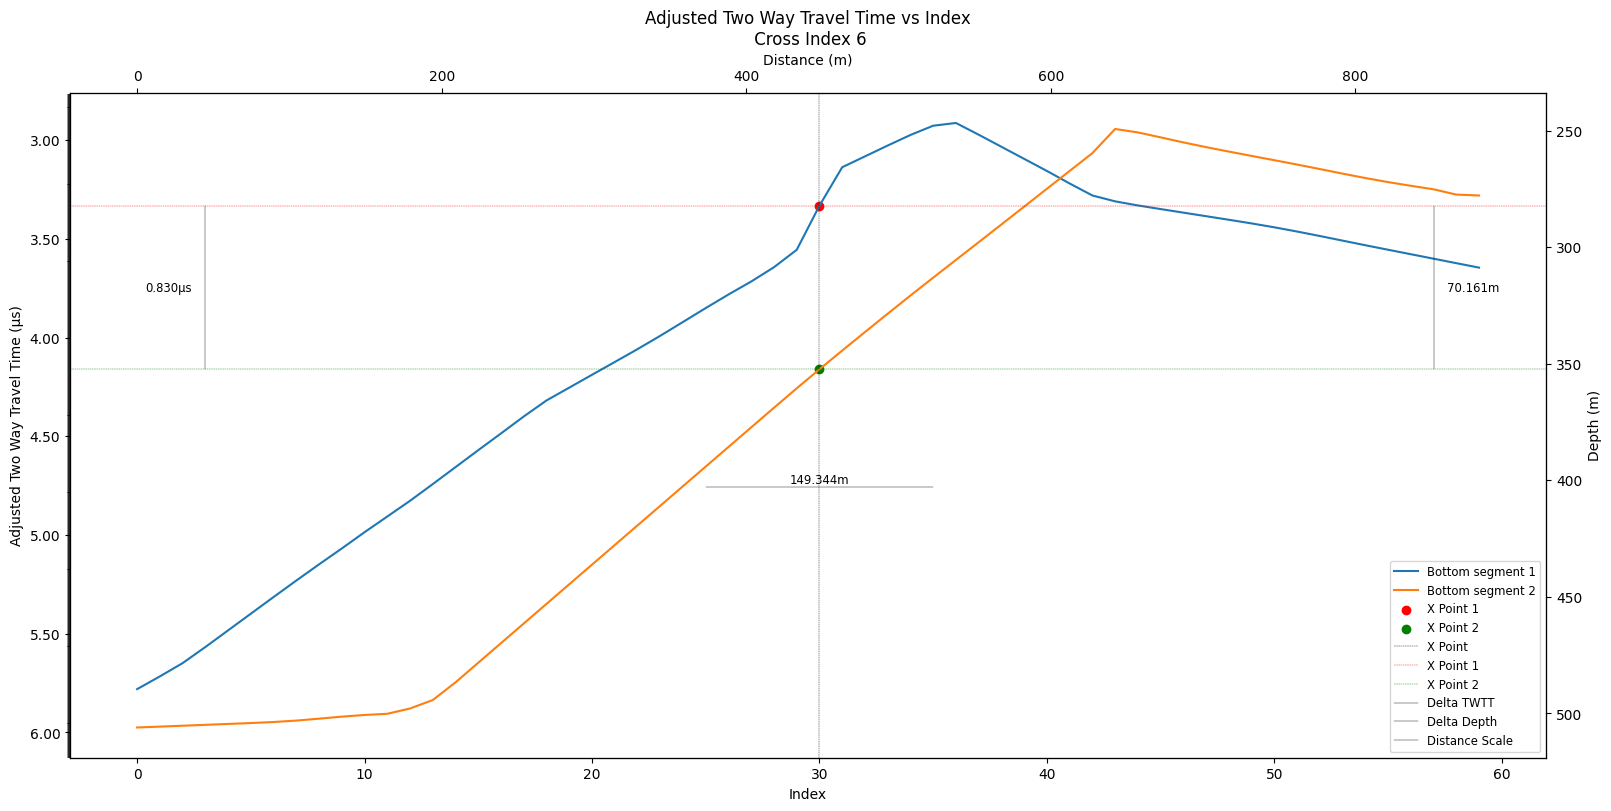

i: 6
twtt: [1.0508794373187518e-05, 1.0662509406036512e-05]


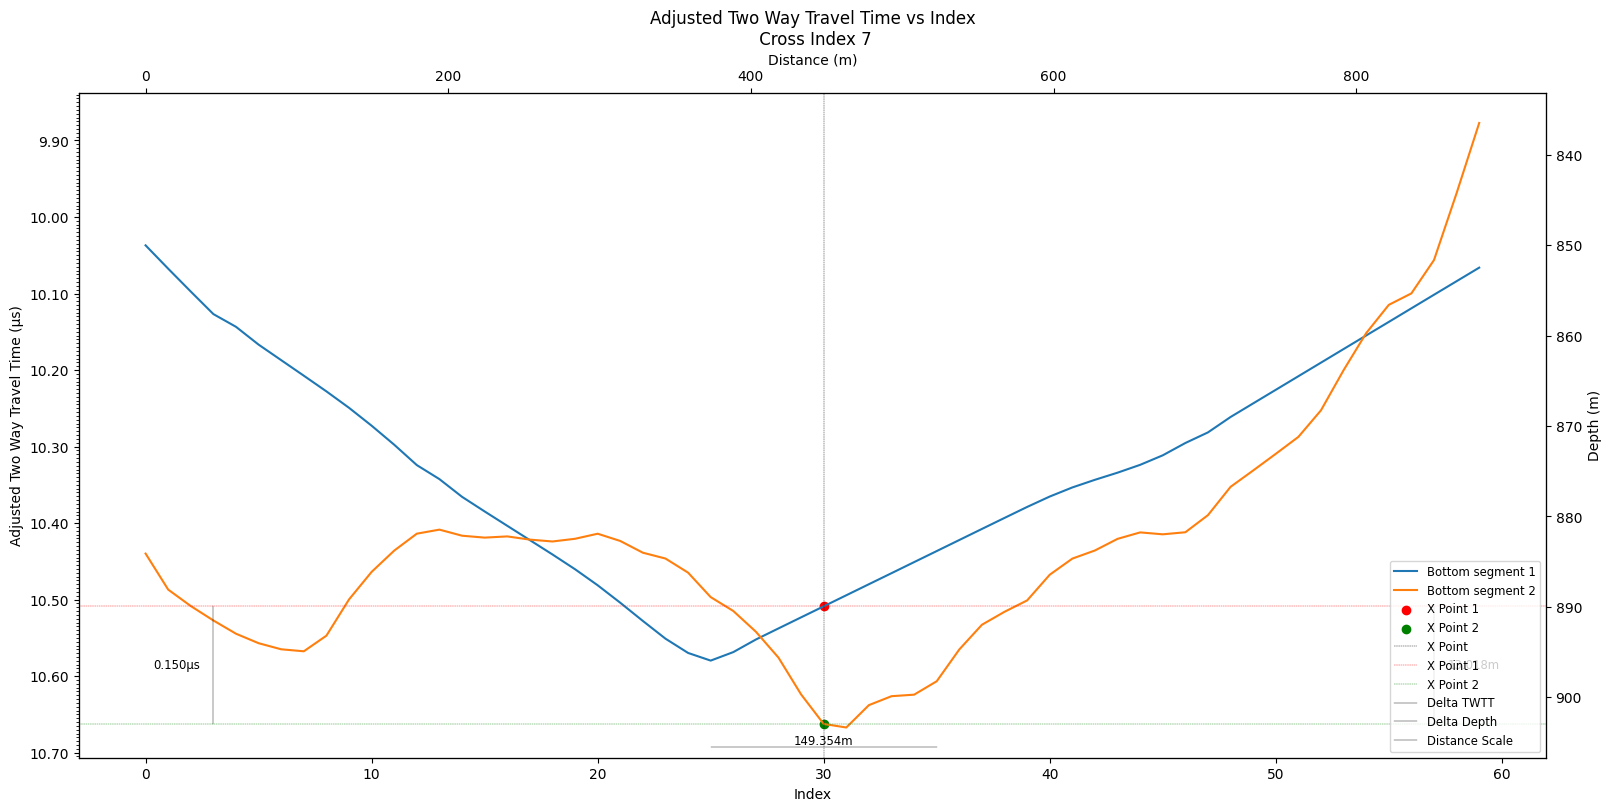

i: 7
twtt: [3.7474799999999996e-05, 3.7543597453563445e-05]


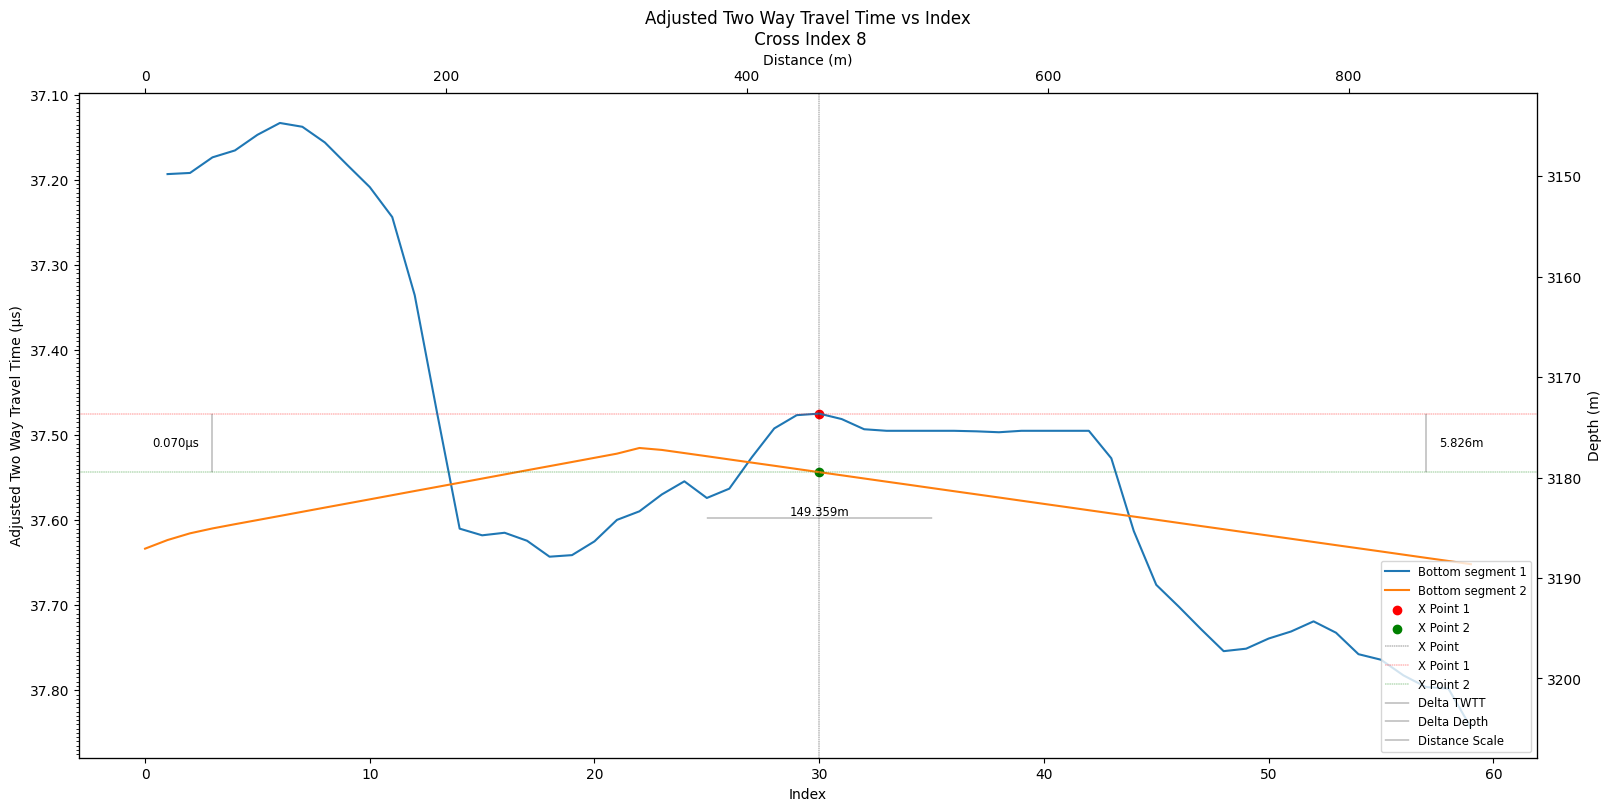

i: 8
twtt: [3.241379866212265e-05, 3.265549772882102e-05]


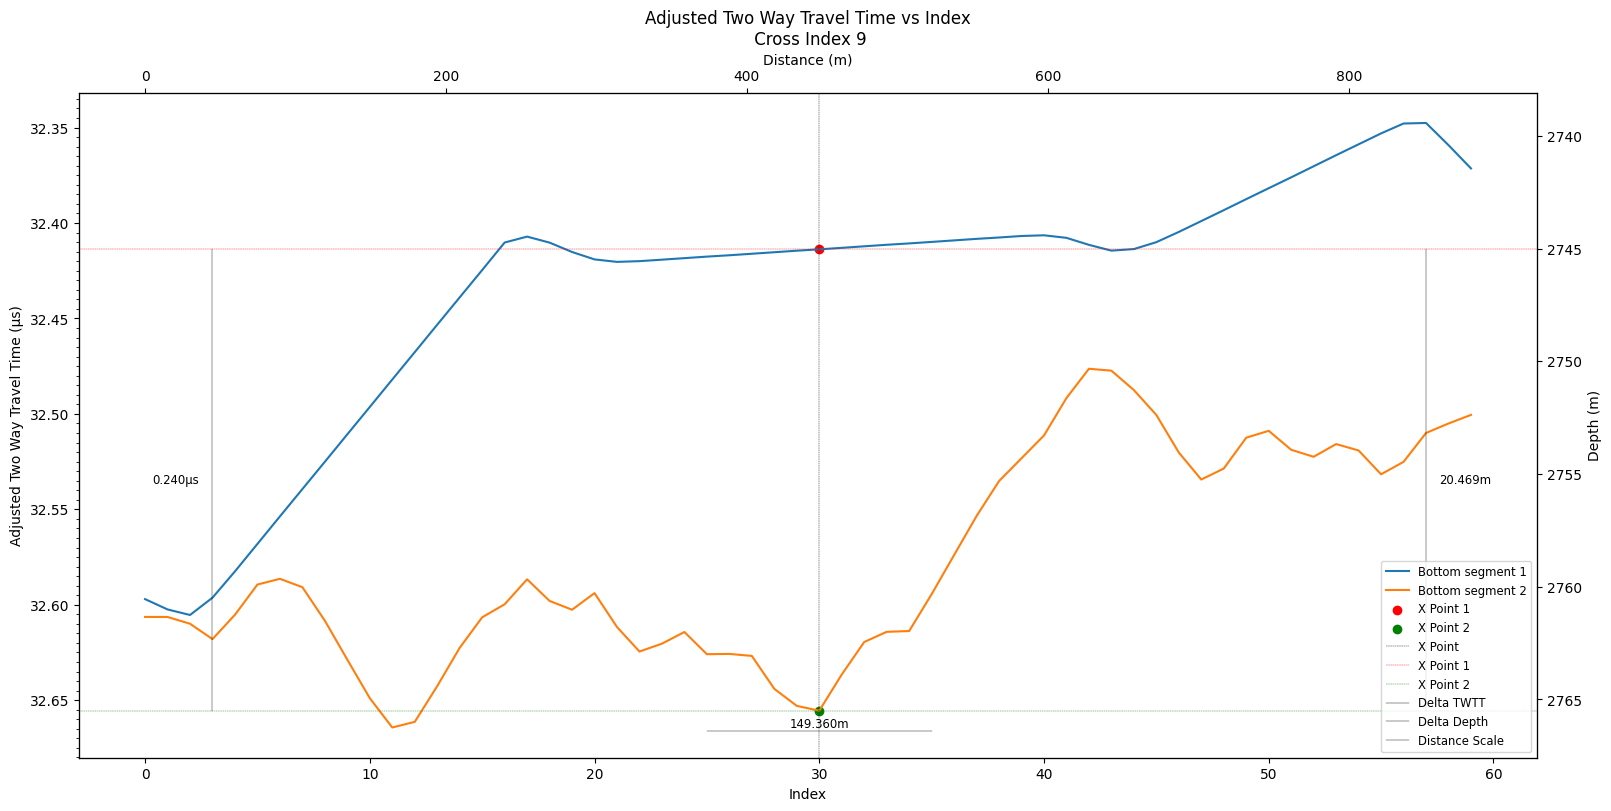

i: 9
twtt: [3.331579781304637e-05, 3.33115e-05]


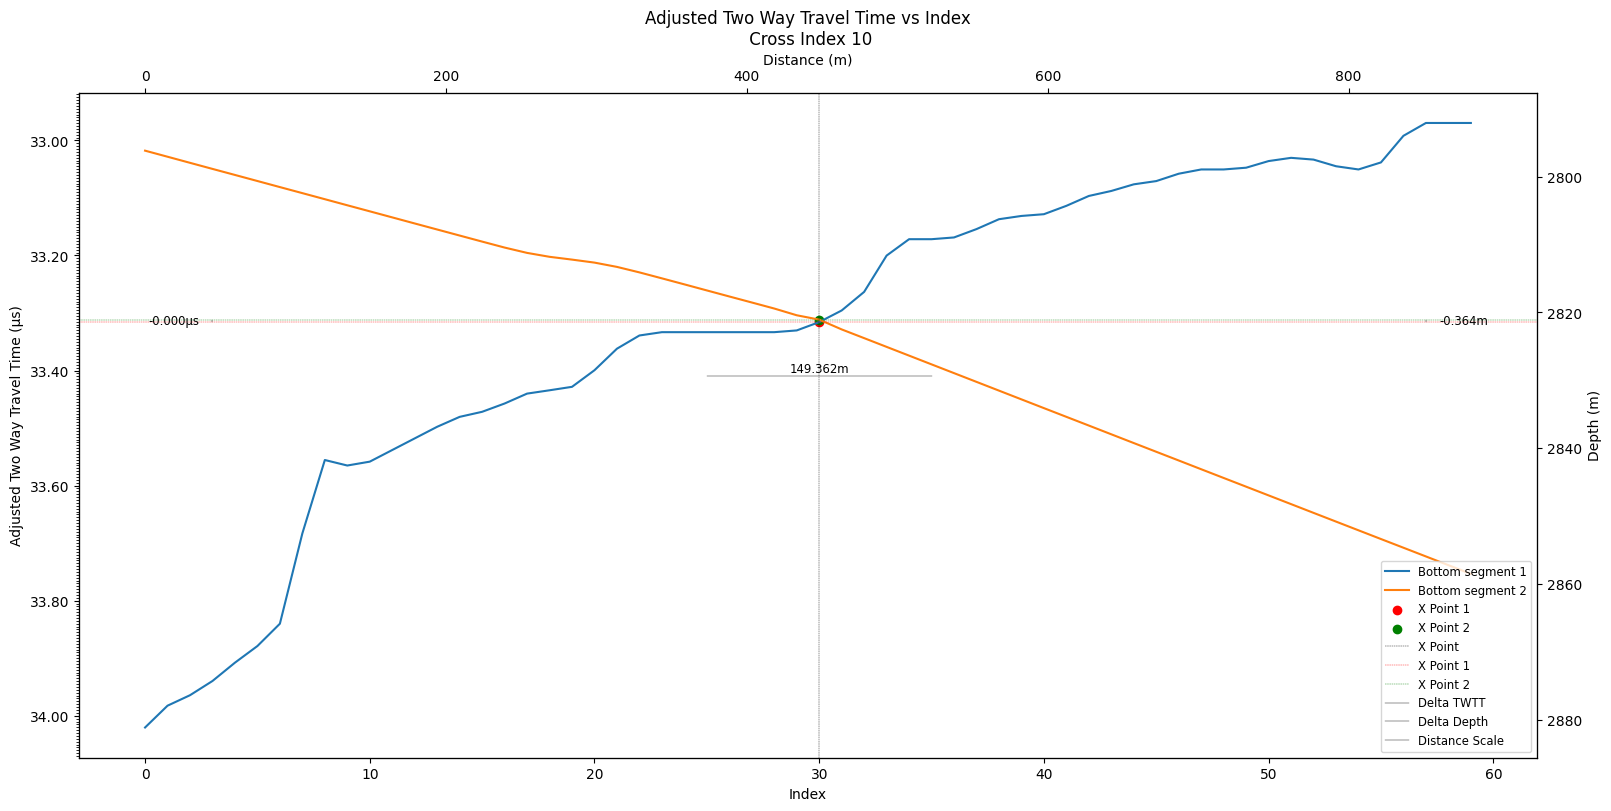

In [151]:
# print(segment_ends[0][0][0][0])
for i in range(len(segment_ends)):
# for i in range(4,5):
    print(f"i: {i}")
    plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=zoom, cross_index=i, filename=(season + flight + "crossover"))
# plot_layers_at_cross(layers, intersection_indices, segment_ends)
# plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=zoom, cross_index=0, filename=(season + flight + "crossover"))
# plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=(season + flight + "crossover")) 

In [152]:
for layer in layers:
        corrected_twtt = layer.twtt - layers[0].twtt  # normalize against the surface layer
        # corrected_twtt = layer.twtt
        layer.twtt_corrected = corrected_twtt

In [153]:
for i in range(len(segment_ends)):
    print(f"corrected_twtt[segment_ends[{i}][0][2]]: \t\t{corrected_twtt[segment_ends[i][0][2]]}")
    print(f"corrected_twtt[segment_ends[{i}][1][2]]: \t\t{corrected_twtt[segment_ends[i][1][2]]}")
    delta = corrected_twtt[segment_ends[i][1][2]] - corrected_twtt[segment_ends[i][0][2]]
    print(f"delta: \t{delta}")
    print(f"depth: \t{twtt_to_depth(delta, refractive_index=1.77)}")
    print(section_break)


corrected_twtt[segment_ends[0][0][2]]: 		3.189429995299016e-05
corrected_twtt[segment_ends[0][1][2]]: 		3.19310862694747e-05
delta: 	3.678631648453771e-08
depth: 	3.115327751317932
--------------------
corrected_twtt[segment_ends[1][0][2]]: 		3.45252e-05
corrected_twtt[segment_ends[1][1][2]]: 		3.459059522132102e-05
delta: 	6.53952213210227e-08
depth: 	5.538133938215651
--------------------
corrected_twtt[segment_ends[2][0][2]]: 		nan
corrected_twtt[segment_ends[2][1][2]]: 		nan
delta: 	nan
depth: 	nan
--------------------
corrected_twtt[segment_ends[3][0][2]]: 		3.3373799999999995e-05
corrected_twtt[segment_ends[3][1][2]]: 		3.3306490795203906e-05
delta: 	-6.730920479608996e-08
depth: 	-5.700223715210508
--------------------
corrected_twtt[segment_ends[4][0][2]]: 		1.8413960828014443e-05
corrected_twtt[segment_ends[4][1][2]]: 		1.8478186797910058e-05
delta: 	6.422596989561519e-08
depth: 	5.4391133848701925
--------------------
corrected_twtt[segment_ends[5][0][2]]: 		3.332426815637665

In [154]:
class Cross:
    def __init__(self):
        self.cross_number = None
        self.flow_xy = None
        self.flow_v = None
        self.intersect_indices = None

        self.flow_heading_full = None
        self.flow_heading = None
        self.plane_heading_1 = None
        self.plane_heading_2 = None
        self.angle = None
        self.twtt = None
        self.delta_twtt = None
        self.depth1 = None
        self.depth2 = None
        self.depth_ave = None
    

    def to_dict(self):
        return {
            'flow_xy': self.flow_xy,
            'flow_heading_full': self.flow_heading_full,
            'flow_heading': self.flow_heading,
            'plane_heading_1': self.plane_heading_1,
            'plane_heading_2': self.plane_heading_2,
            'angle': self.angle,
            'twtt': self.twtt,
            'delta_twtt': self.delta_twtt,
            'depth1': self.depth1,
            'depth2': self.depth2,
            'depth_ave': self.depth_ave
        }
          
          
    def to_dict(self):
        return self.__dict__

    def __str__(self):
        attributes = self.to_dict()
        str_repr = '\n'.join(f"{key}: {value}" for key, value in attributes.items())
        return str_repr
    
    # def __str__(self):
    #     str = f"flow_xy: {self.flow_xy}\n" \
    #           f"flow_heading_full: {self.flow_heading_full}\n" \
    #           f"flow_heading: {self.flow_heading}\n" \
    #           f"plane_heading_1: {self.plane_heading_1}\n" \
    #           f"plane_heading_2: {self.plane_heading_2}\n" \
    #           f"angle: {self.angle}\n" \
    #           f"twtt: {self.twtt}\n" \
    #           f"delta_twtt: {self.delta_twtt}\n" \
    #           f"depth1: {self.depth1}\n" \
    #           f"depth2: {self.depth2}\n" \
    #           f"depth_ave: {self.depth_ave}"
    #     return str


# TODO: 1July24 x and y are still mixed up here from how they are used below
- go line by line and verify against QGIS for every function and function call starting from the top.
    - transpose the matrix in flow_data_file_loader() and call it good?

In [155]:
# repeat the above for every crossover point
flow_xy = [] # the flow vector in xy 
flow_heading_full = [] # the flow vector heading in angle1, angle2, distance (in meters)
flow_heading = []
plane_heading_1 = []
plane_heading_2 = []
angle = [] # the angle between the flow vector and the plane heading
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)
delta_twtt = []
depth1 = []
depth2 = []
depth = []

cross_points = []

for i in range(len(intersection_indices)):
    print(f"intersection {i}")
    point = Cross()
    # convert the lat-lon point to xy and then to indices
    lat, lon = intersection_points[i]     
    print(f"lat: {lat}, lon: {lon}")
    x, y = latlon_to_xy(lat, lon)
    print(f"x: {x}, y: {y}")
    x_index, y_index = x_to_index(x), y_to_index(y)
    # nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)
    nearest_x_index, nearest_y_index = latlon_to_nearest_unmasked_index(lat, lon, iceflow_data, max_radius=10, printout=True)
    
    print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
    
    point.intersect_indices = intersection_indices[i]
    
    nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]
    nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]
    print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")

    point.flow_xy = [iceflow_data[2][nearest_y_index][nearest_x_index], iceflow_data[3][nearest_y_index][nearest_x_index]]
    print(f"flow at nearest: {point.flow_xy}")
    
    point.flow_v = np.sqrt(point.flow_xy[0]**2 + point.flow_xy[1]**2)
    

    print(f"flow at nearest: {point.flow_xy}")
    
    # find the heading of the flow vector   
    point.flow_heading_full = xyindex_vector_to_heading(nearest_x_index, nearest_y_index, point.flow_xy[0], point.flow_xy[1])
    
    point.flow_heading = point.flow_heading_full[0]
    
    print(f"flow_heading[{i}]: {point.flow_heading}")
    print(f"flow_v[{i}]: {point.flow_v}")
    # print(f"flow_heading_v: {point.flow_heading_full[2]}")
    
    # find the heading of the first segment
    point.plane_heading_1 = find_heading(layers[0], intersection_indices[i][0])


    # find the heading of the second segment
    point.plane_heading_2 = find_heading(layers[0], intersection_indices[i][1])
    
    plane_flow_angle = max(abs(point.plane_heading_1 - point.flow_heading), abs(point.plane_heading_2 - point.flow_heading))

    point.angle = plane_flow_angle

    # point.delta_twtt = abs(twtt[i][1] - twtt[i][0])
    # point.twtt = twtt[i]
    print(f"twtt[{i}]: {twtt[i]}")
    point.twtt = twtt[i]
    
    point.delta_twtt = (abs(corrected_twtt[intersection_indices[i][1]] - corrected_twtt[intersection_indices[i][0]]))
    
    point.cross_number = i + 1
    
    # print(f"twtt[{i}]: {point.twtt}
    # print(f"twtt[{i}]: {point.twtt[0]:.20f}, {point.twtt[1]:.20f}")
    print(f"delta_twtt[{i}]: {point.delta_twtt:.20f}")
    
    # print the depth of the crossover point
    point.depth1 = twtt_to_depth(twtt[i][0], refractive_index=1.77)
    point.depth2 = twtt_to_depth(twtt[i][1], refractive_index=1.77)
    point.depth_ave = (point.depth1 + point.depth2) / 2
    print(section_break)        
    cross_points.append(point)
    
# print(cross_points[1])

intersection 0
lat: -81.11816244525122, lon: 330.2649048355562
x: -479569.56069901184, y: 839579.5925020133
The calculated indices are unmasked, no need to search
nearest_x_index: 5157, nearest_y_index: 4356
nearest_lat: -81.1174078311801, nearest_lon: 330.282678652
flow at nearest: [-176.06517, -119.391495]
flow at nearest: [-176.06517, -119.391495]
flow_heading[0]: -94.41645213989642
flow_v[0]: 212.72816740489532
twtt[0]: [3.189429995299016e-05, 3.19310862694747e-05]
delta_twtt[0]: 0.00000003678631648454
--------------------
intersection 1
lat: -81.16768709742837, lon: 331.6942013208803
x: -455912.20531389076, y: 846515.5991654578
The calculated indices are unmasked, no need to search
nearest_x_index: 5209, nearest_y_index: 4340
nearest_lat: -81.16362069338335, nearest_lon: 331.7059003807609
flow at nearest: [-189.62747, -165.06949]
flow at nearest: [-189.62747, -165.06949]
flow_heading[1]: -102.73670324628206
flow_v[1]: 251.40905741491554
twtt[1]: [3.45252e-05, 3.459059522132102e-05

things not deleting correctly, shift to class objects

In [156]:
# print(cross_points[0].__dict__)
# dir(cross_points[0])
keys = cross_points[0].to_dict().keys()
# print(keys)
for cross in cross_points:
    for key in keys:
        # print(f"{key}: {cross.to_dict()[key]}")
        if cross.to_dict()[key] is None:
            print("None found")
            print(section_break)
        if cross.to_dict()[key] is np.nan:
            print("nan found - numpy")
            print(section_break)
        if key == "twtt":
            if math.isnan(cross.to_dict()[key][0]):
                print("nan found, cross removed")
                cross_points.remove(cross)
                print(section_break)
                
        

nan found, cross removed
--------------------


In [157]:
print(f"length of cross_points: {len(cross_points)}")

length of cross_points: 9


In [158]:
i = 0
length = len(cross_points)
while i < length:
    delta_heading = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)
    if delta_heading > 180:
        print(f"subtracted 180 from delta_heading: {delta_heading}")
        delta_heading -= 180
    print(f"delta_heading: {delta_heading}")
    
    if (delta_heading < 75) or (delta_heading > 105):
        cross_points.remove(cross_points[i])
        print(f"removed index {i} with delta_heading: {delta_heading}")
        length -= 1

    i += 1
print(f"length of cross_points: {len(cross_points)}")
    
    

delta_heading: 103.94093208490197
delta_heading: 74.61532263184618
removed index 1 with delta_heading: 74.61532263184618
delta_heading: 58.265087484818295
removed index 2 with delta_heading: 58.265087484818295
subtracted 180 from delta_heading: 253.1309436773651
delta_heading: 73.13094367736511
removed index 3 with delta_heading: 73.13094367736511
delta_heading: 38.02346584421913
removed index 4 with delta_heading: 38.02346584421913
length of cross_points: 5


In [25]:
i = 0
length = len(cross_points)
while i < length:
    slope1 = average_slope_around_index(layers[0], cross_points[i].intersect_indices[0], 100)
    slope2 = average_slope_around_index(layers[0], cross_points[i].intersect_indices[1], 100)
    # print(f"slope1: {slope1}, slope2: {slope2}")
    if slope1 > 0.3 or slope2 > 0.3:
        cross_points.remove(cross_points[i])
        print(f"removed index {i} with slope1: {slope1}, slope2: {slope2}")
        length -= 1
    
    i += 1

removed index 0 with slope1: 0.5679209243356871, slope2: 0.10320859440230516


# Pressing TODO
- point conversion seems to be working so far
- need to investigate wht flow headings are varying over small distances
    - is this still an issue after 28Jun24?

# TODO: functionize this plot once it works

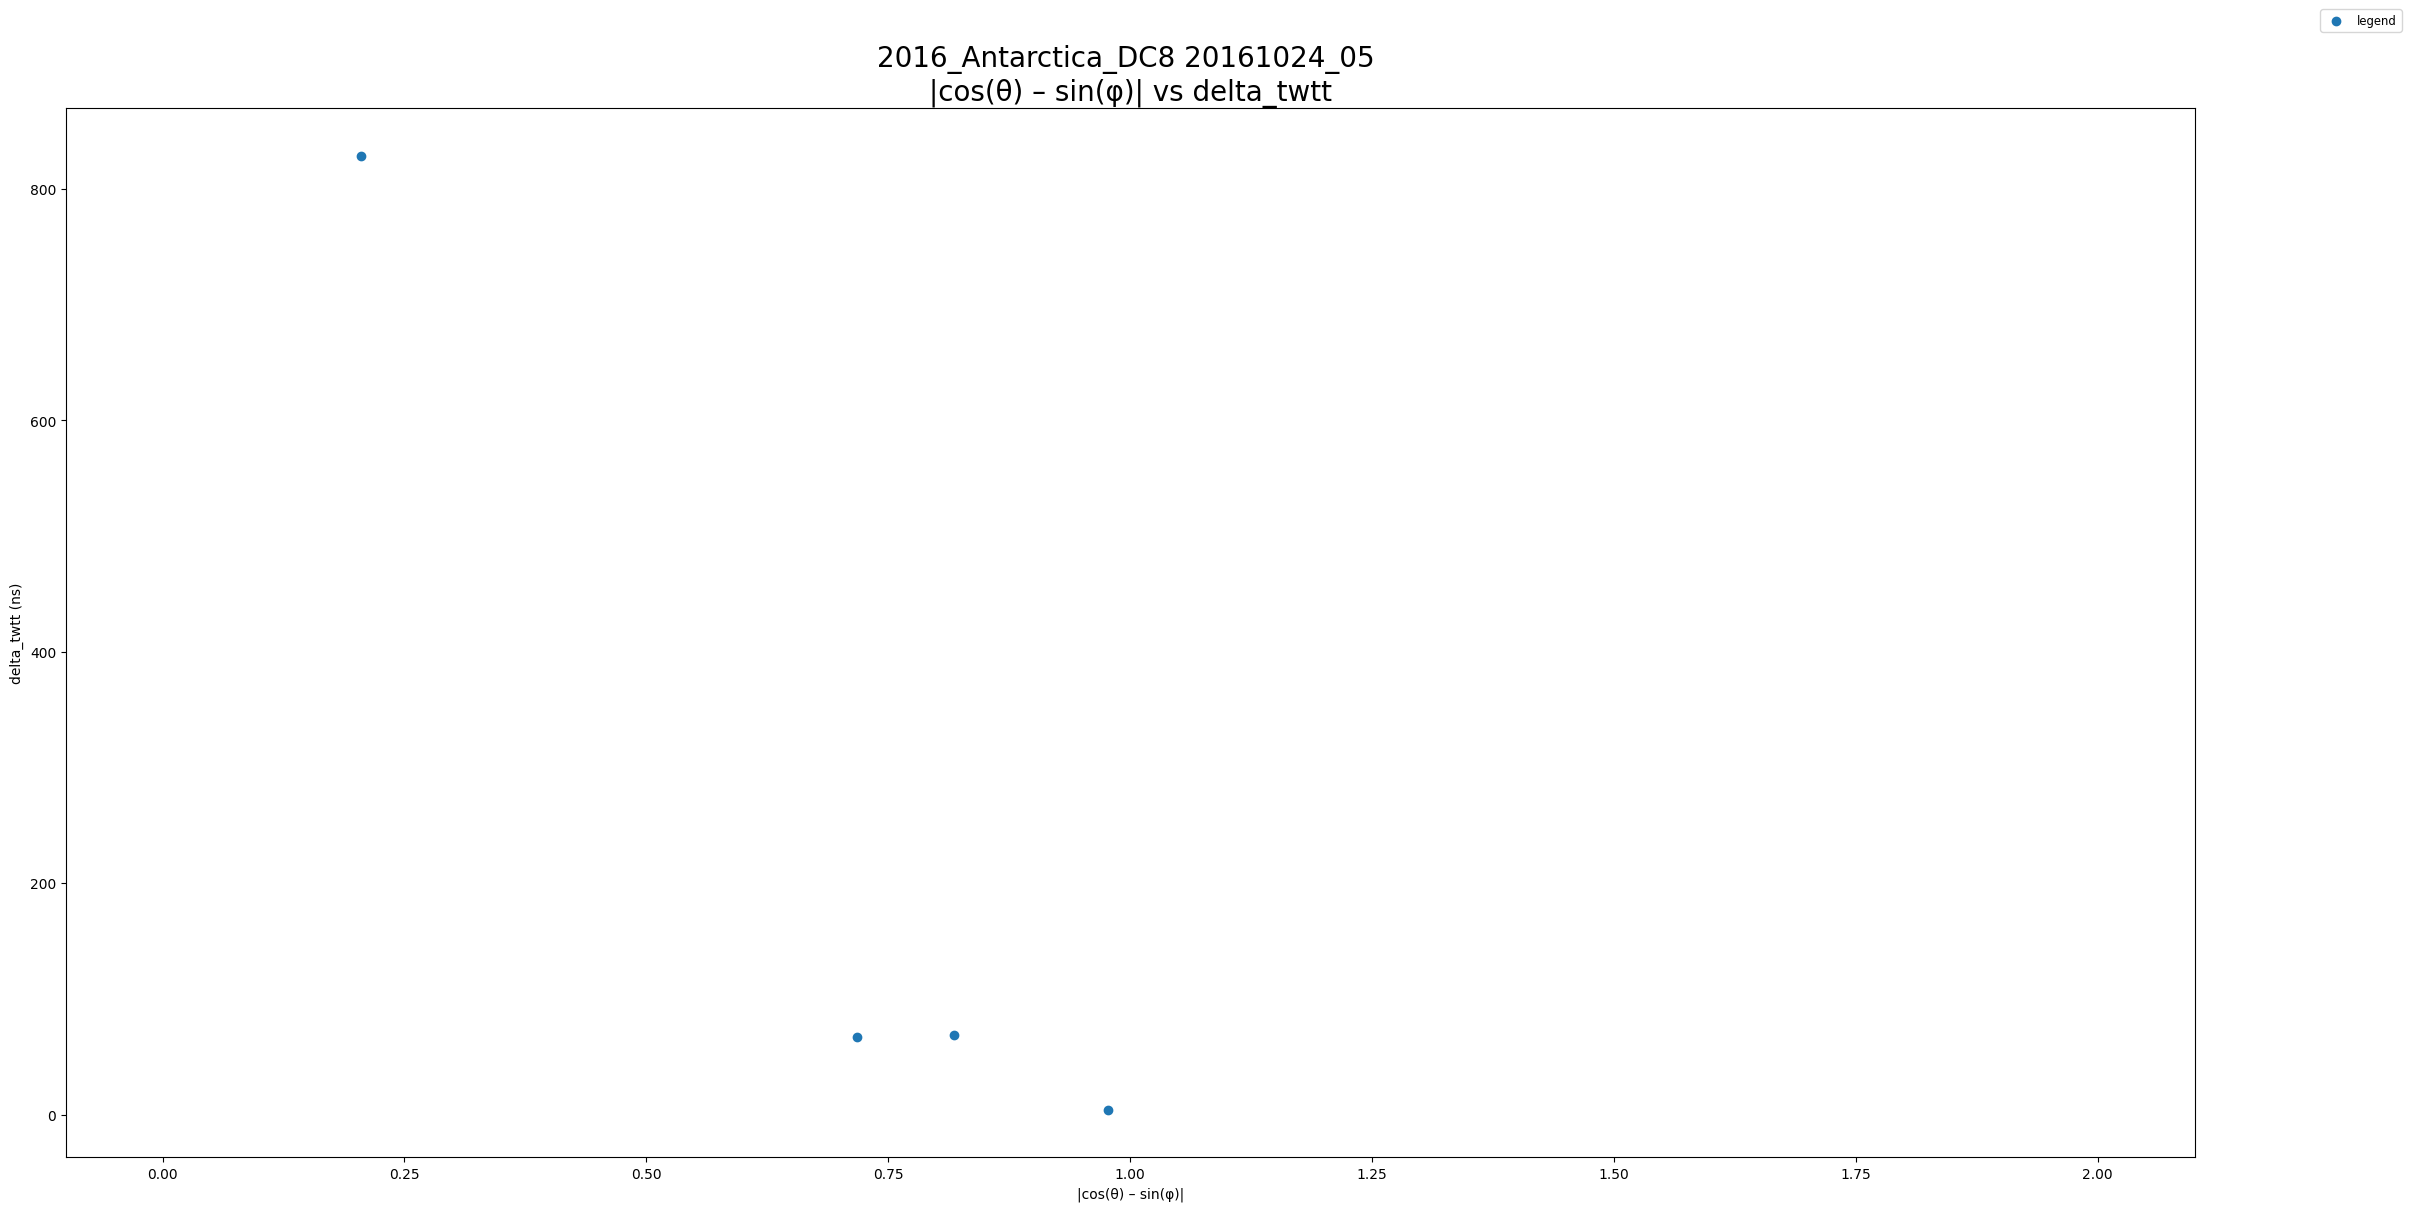

saved plot as C:\Users\moser\Desktop\cresis_project\screens\2016_Antarctica_DC8_20161024_05_cos_angle_heading_vs_delta_twtt.png


In [26]:
plt.figure(figsize=(24, 12), layout='constrained')
xdata = []
ydata = []

for i in range(len(cross_points)):
    if math.isnan(cross_points[i].delta_twtt):
        debug_print(f"skipping index {i} because delta_twtt is nan")
        continue
    theta = cross_points[i].angle
    phi = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)
    delta_twtt_micros = cross_points[i].delta_twtt * 1e6
    delta_twtt_ns = cross_points[i].delta_twtt * 1e9
        
    xdata = np.append(xdata, np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))))  # |cos(θ) – sin(φ)|
    ydata = np.append(ydata, delta_twtt_ns)


plt.scatter(xdata,ydata)

plt.xlabel("|cos(θ) – sin(φ)|")
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)
# get the current directory
dir = os.getcwd()

plt.ylabel("delta_twtt (ns)")
plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.yscale('log')
    
# print(f"abs(max(delta_twtt)): {abs(max(delta_twtt))}")
# set the x bounds to -0.1 to 2.1
plt.xlim(-0.1, 2.1)


plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)


plt.yscale('linear')
# save the plot as a png file with a high dpi named after the season and flight
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt.png")

Using nanoseconds


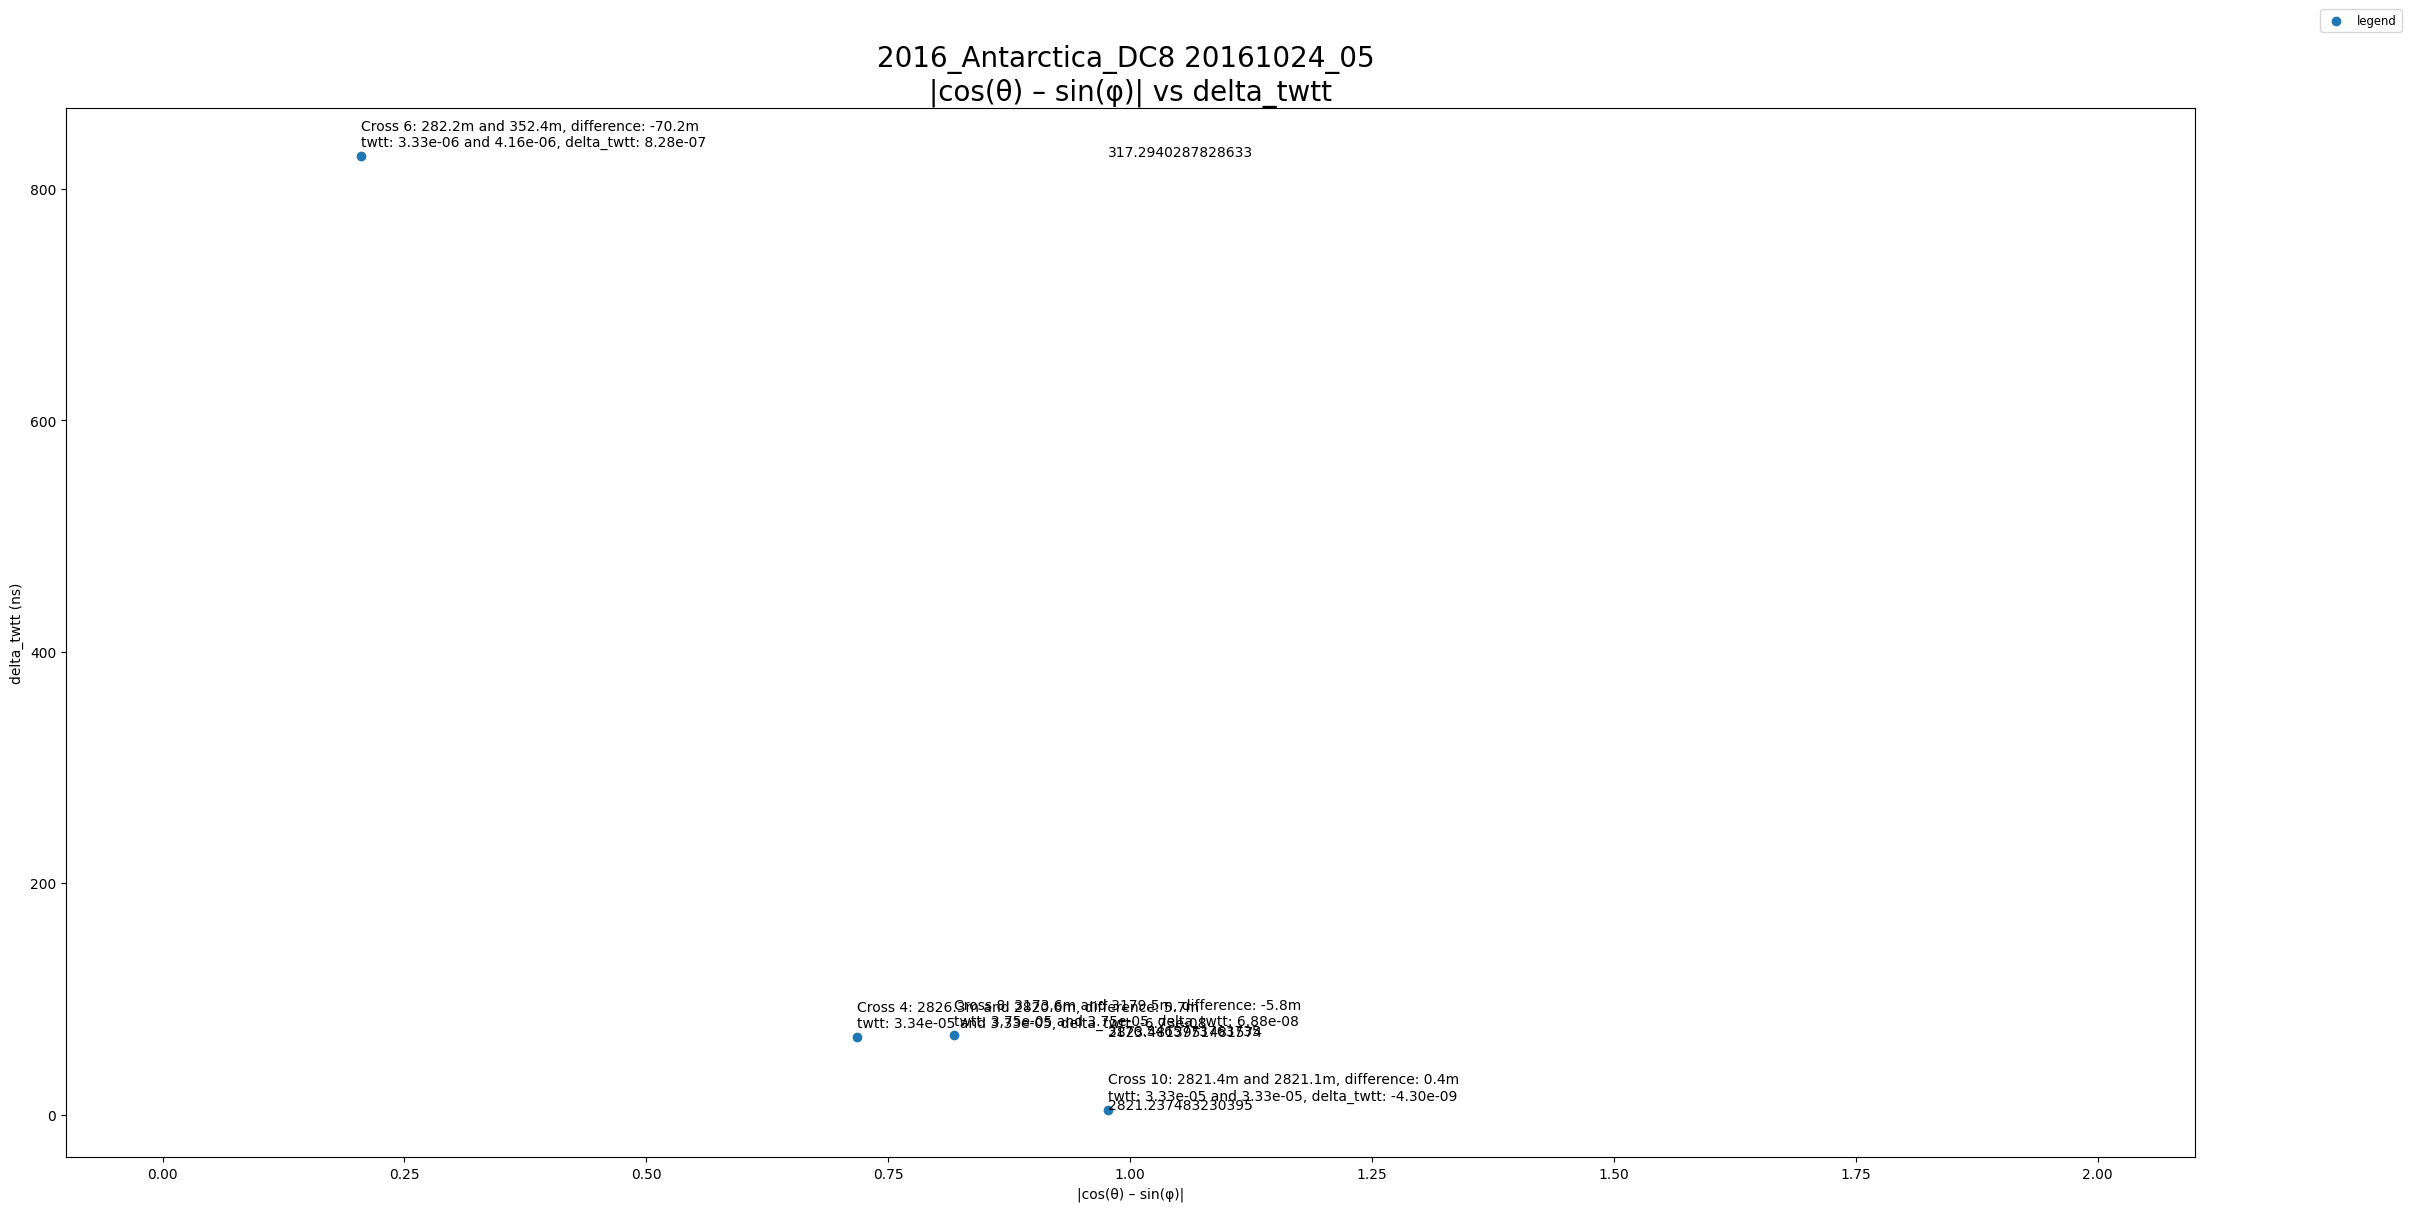

saved plot as C:\Users\moser\Desktop\cresis_project\screens\2016_Antarctica_DC8_20161024_05_cos_angle_heading_vs_delta_twtt.png


In [27]:
"""
Delete and start over?
"""

micro = False
print_time = True

plt.figure(figsize=(24, 12), layout='constrained')
xdata = []
ydata = []

for i in range(len(cross_points)):
    if math.isnan(cross_points[i].delta_twtt):
        debug_print(f"skipping index {i} because delta_twtt is nan")
        continue
    theta = cross_points[i].angle
    phi = abs(cross_points[i].plane_heading_1 - cross_points[i].plane_heading_2)
    delta_twtt_micros = cross_points[i].delta_twtt * 1e6
    delta_twtt_ns = cross_points[i].delta_twtt * 1e9
        
    xdata = np.append(xdata, np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))))  # |cos(θ) – sin(φ)|
    
    if micro:    
        delta_twtt_unit = delta_twtt_micros  # delta_twtt (µs)
        if print_time: 
            print("Using microseconds")
            print_time = False
    else:
        delta_twtt_unit = delta_twtt_ns  # delta_twtt (ns)
        if print_time: 
            print("Using nanoseconds")
            print_time = False
            
    ydata = np.append(ydata, delta_twtt_unit)

y_label_offset = max(ydata) * .01
for i in range(len(xdata)):
    if math.isnan(xdata[i]):
        debug_print(f"skipping index {i} because xdata is nan")
        continue
    if math.isnan(ydata[i]):
        debug_print(f"skipping index {i} because ydata is nan")
        continue
    # plt.text(xdata[index], ydata[index] + y_label_offset, f"Cross {index+1}: {depth[index]:.1f}m", fontsize=10)
    plt.text(xdata[i], ydata[i] + y_label_offset, f"Cross {cross_points[i].cross_number}: {cross_points[i].depth1:.1f}m and {cross_points[i].depth2:.1f}m, difference: {cross_points[i].depth1 - cross_points[i].depth2:.1f}m\ntwtt: {cross_points[i].twtt[0]:.2e} and {cross_points[i].twtt[1]:.2e}, delta_twtt: {cross_points[i].twtt[1] - cross_points[i].twtt[0]:.2e}", fontsize=10)
    plt.text(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), ydata[i], f"{cross_points[i].depth_ave}", fontsize=10)

        
# print(f"xdata: {xdata}")
plt.scatter(xdata,ydata)

plt.xlabel("|cos(θ) – sin(φ)|")
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)

# get the current directory
dir = os.getcwd()

plt.ylabel("delta_twtt (ns)")
plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.yscale('log')
# print(f"abs(max(delta_twtt)): {abs(max(delta_twtt))}")
# set the x bounds to -0.1 to 2.1
plt.xlim(-0.1, 2.1)

plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)

plt.yscale('linear')
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt.png")
# |cos(90) - sin(90)| = 0 - 1 = 1
# plot should peak either at 1 or 0 depending on which flight is closer to the flow vector
    # in theory it should be around 1 but it could be 0 if coded wrong

# END OF RELEVANT CODE FOR ARA TALK

In [20]:
# x_data = np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1))))
# y_data = delta_twtt
# 
# # Define the Gaussian function
# def gaussian(x, amplitude, mean, stddev):
#     return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
# 
# # Initial parameter guesses: amplitude close to your data's scale, mean around the center, and a reasonable stddev
# initial_guesses = [1e-8, 0.5, 0.1]
# 
# # Use curve_fit to fit the Gaussian function to your data
# popt, pcov = opt.curve_fit(gaussian, x_data, y_data, p0=initial_guesses, maxfev=5000)
# 
# # Plot the original data
# plt.scatter(x_data, y_data, label='Data')
# 
# # Plot the fitted curve
# x_fit = np.linspace(min(x_data), max(x_data), 1000)
# y_fit = gaussian(x_fit, *popt)
# plt.plot(x_fit, y_fit, color='red', label='Fitted curve')
# 
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Gaussian Fit to Data')
# plt.legend()
# plt.show()

ntuple-ize
    cos(heading-flow)
    difference in theta paralell and perpindicular
    delta_twtt
    v_flow
- stop selecting for angle in upper cells, we can cut the data once we have it
